# Introduction

The CIFAR 10 and MNIST datasets are like the hello world of Deep Learning for people trying to get an understanding of Deep Neural Networks and Covolutional Neural Networks.

The MNIST dataset is the easier of the two because we have fewer low level features and 1 color channel (i.e white & black) rather than 3 color channels (Red.Green.Blue). For those reasons, it's easy to achieve high accuracy on the MNIST dataset than the CIFAR 10.

In this notebook, i will build 3 CNN models:
* model 1: Without Image Augmentation
* model 2: With Image Augmentation
* model 3: Pretrained Layers (Transfer Learning)

## Problem Definition

Can we accurately predict the class an image belongs to?

We have 60,000 images of shape 32 x 32 with 3 color channels (R.G.B)
These images contain 10 classes: 
* Airplane
* Automobile
* Bird
* Cat
* Deer 
* Dog
* Frog
* Horse
* Ship
* Truck

## Importing the Libraries

In [1]:
import numpy as np
from numpy import expand_dims
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix

## Splitting the data

In [2]:
# Loading the dataset
(X_trainfull, y_trainfull), (X_test, y_test) = keras.datasets.cifar10.load_data()

#Splitting the trainfull set into train and validation set
X_train, X_valid = X_trainfull[:-5_000], X_trainfull[-5_000:]
y_train, y_valid = y_trainfull[:-5_000], y_trainfull[-5_000:]

label_names = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

170500096/170498071 [==============================] - 3s 0us/step


### Scaling the data
 Our data ranges from 0 ~ 255 but Neural Networks work best when they scaled betweeen a range of 0 ~ 1. Therefore i will be rescaling our downloaded data by dividing our instances by a float `255.0`

In [3]:
# Scaling the data
X_train = X_train / 255.
X_valid = X_valid / 255.
X_test = X_test / 255.

# Coverting the target values to 1 dimension
y_train = y_train.ravel()
y_valid = y_valid.ravel()
y_test = y_test.ravel()

Because we have 10 classes with values 0 ~ 9 representing each class, we have to convert our target values to categorical by using the implementation of One-Hot Encoding in keras.

In [4]:
# Converting target values to Categorical

y_train_cat = to_categorical(y_train, 10)
y_valid_cat = to_categorical(y_valid, 10)
y_test_cat = to_categorical(y_test, 10)

# Visualization
### Loading 225 sample Images
Next i am going to visualize 225 images from our data together with their respective class.

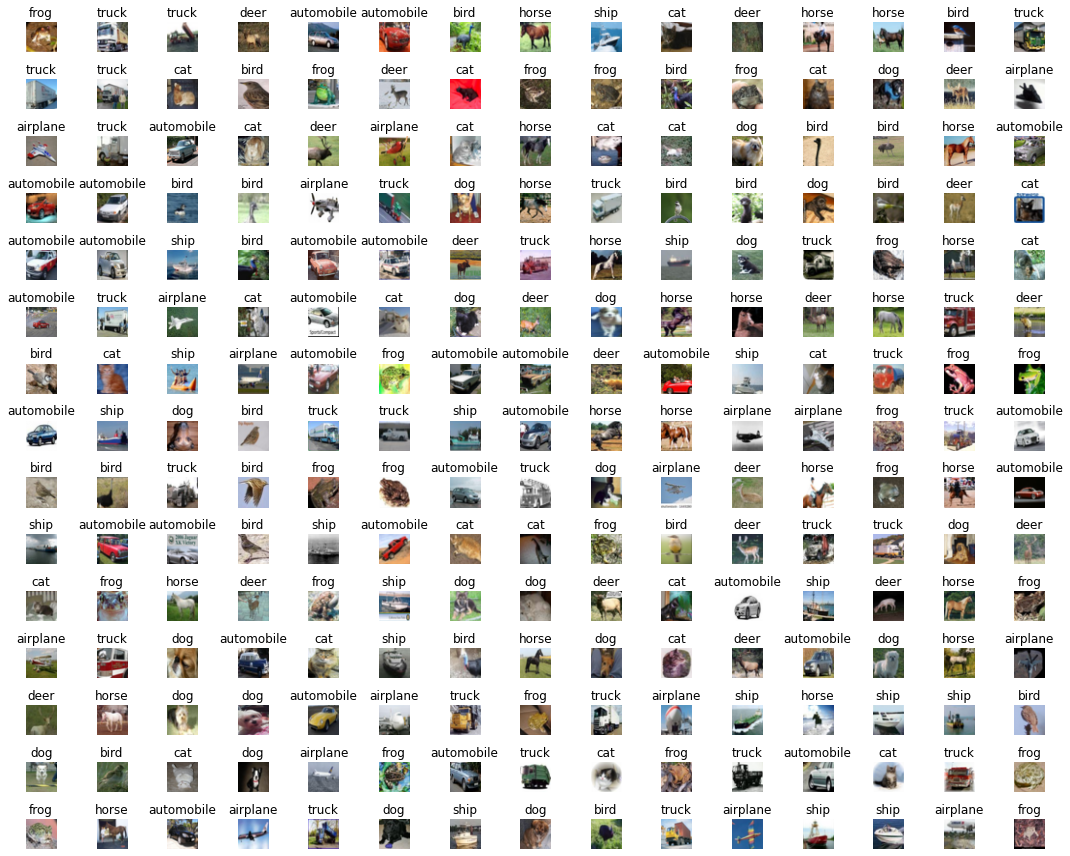

In [5]:
plt.figure(figsize=(15,12))
for i in range (225):
    plt.subplot(15, 15, i+1)
    plt.imshow(X_train[i])
    plt.title(np.array(label_names)[y_train[i]])
    plt.axis("off")
plt.tight_layout()
plt.show()

#### Visualizing the Count of our target classes in our train set

In [6]:
df = pd.DataFrame(np.array(label_names)[y_train])
df = pd.DataFrame({"Count":df.value_counts()})
df = df.reset_index().rename({0:"Category"}, axis = 1)
df.style.bar(color = "#f43f1a", vmin=4450.0)

,Category,Count
0,deer,4525
1,bird,4521
2,horse,4515
3,automobile,4512
4,frog,4512
5,airplane,4507
6,truck,4488
7,cat,4481
8,dog,4471
9,ship,4468


Finding the Percentage of each category in the dataset

In [7]:
print("y_train Percentage:")
round(pd.DataFrame(np.array(label_names)[y_train].ravel()).value_counts(normalize=True)*100,2)

y_train Percentage:


deer          10.06
bird          10.05
horse         10.03
automobile    10.03
frog          10.03
airplane      10.02
truck          9.97
cat            9.96
dog            9.94
ship           9.93
dtype: float64

In [8]:
print("y_valid Percentage:")
round(pd.DataFrame(np.array(label_names)[y_valid].ravel()).value_counts(normalize=True)*100,2)

y_valid Percentage:


ship          10.64
dog           10.58
cat           10.38
truck         10.24
airplane       9.86
automobile     9.76
frog           9.76
horse          9.70
bird           9.58
deer           9.50
dtype: float64

In [9]:
print("y_test Percentage:")
round(pd.DataFrame(np.array(label_names)[y_test].ravel()).value_counts(normalize=True)*100,2)

y_test Percentage:


airplane      10.0
automobile    10.0
bird          10.0
cat           10.0
deer          10.0
dog           10.0
frog          10.0
horse         10.0
ship          10.0
truck         10.0
dtype: float64

# Building the Model

Before we build the model, why do we use use COnvolutional Networks for Image Problems instead of Deep fully connected Neural Networks?

Well, deep neural networks with fully connected layers work well for small image problems like the MNIST dataset because of fewer low level features which means it will have less paramters to tune. For example, a 100 x 100 image has 10,000 pixels and if the first layer contains 500 neurons that means there will be 5,000,000 connections that have to be tweaked during training (especially backpropagation). This makes it incredibly difficult to obtain good accuracy on image classification tasks. 
Convolutional Neural Networks slove this problem by connecting each neuron to only pixels in a layers receptive field with the aid of filters (which pick up low level features which are then combined to form complex patterns in subsequent convolutional layers). CNNs also share weigths for each filter map, meaning there are significantly lesser parameters to tune.

Finally, once a CNN recognizes a pattern/feature at a location it can locate it in any other location. Whereas, DNNs can only recognize it on that same location.

### 1.0 Without Image Augmentation

In [10]:
from functools import partial

# setting a random seed for reproducibilty of results
np.random.seed(42)
tf.random.set_seed(42)

keras.backend.clear_session()

# creating a Default convolutional layer
DefaultConv = partial(keras.layers.Conv2D, strides = 1, kernel_size = 3, padding = 'same', activation = 'relu')

model = keras.models.Sequential([
    DefaultConv(filters = 32, input_shape = [32,32,3]),
    keras.layers.BatchNormalization(),
    DefaultConv(filters = 32, kernel_size = 5),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Dropout(0.2),
    
    DefaultConv(filters = 64),
    keras.layers.BatchNormalization(),
    DefaultConv(filters = 64),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Dropout(0.3),
    
    DefaultConv(filters = 128),
    keras.layers.BatchNormalization(),
    DefaultConv(filters = 128),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Dropout(0.4),
    
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation = 'relu', kernel_initializer = 'he_normal', use_bias = False),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(10, activation = 'softmax'),
])

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        25632     
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        1

In [12]:
model.compile(loss="categorical_crossentropy", metrics=['accuracy'],
             optimizer = 'nadam')

In [13]:
# To save the best model so far during training
Checkpoint_cb = keras.callbacks.ModelCheckpoint("No_Augmentation_model.h5", save_best_only=True)

# To stop training if our validation loss has not improved after 10 epochs
Earlystopping_cb = keras.callbacks.EarlyStopping(patience=10)


callback = [Checkpoint_cb, Earlystopping_cb]

In [14]:
history = model.fit(X_train, y_train_cat, epochs = 100,
    validation_data = (X_valid, y_valid_cat),
    callbacks=callback)

Epoch 1/100
1407/1407 [==============================] - 21s 9ms/step - loss: 2.1301 - accuracy: 0.2553 - val_loss: 1.4937 - val_accuracy: 0.4680
Epoch 2/100
1407/1407 [==============================] - 12s 9ms/step - loss: 1.4417 - accuracy: 0.4787 - val_loss: 1.1403 - val_accuracy: 0.5918
Epoch 3/100
1407/1407 [==============================] - 12s 9ms/step - loss: 1.2004 - accuracy: 0.5781 - val_loss: 0.9022 - val_accuracy: 0.6832
Epoch 4/100
1407/1407 [==============================] - 12s 9ms/step - loss: 1.0349 - accuracy: 0.6396 - val_loss: 0.8082 - val_accuracy: 0.7060
Epoch 5/100
1407/1407 [==============================] - 13s 9ms/step - loss: 0.9352 - accuracy: 0.6781 - val_loss: 1.1731 - val_accuracy: 0.5930
Epoch 6/100
1407/1407 [==============================] - 12s 9ms/step - loss: 0.8692 - accuracy: 0.7033 - val_loss: 0.7489 - val_accuracy: 0.7366
Epoch 7/100
1407/1407 [==============================] - 12s 9ms/step - loss: 0.7925 - accuracy: 0.7270 - val_loss: 0.6146 -

In [15]:
model = keras.models.load_model("No_Augmentation_model.h5")

model.evaluate(X_test, y_test_cat)

313/313 [==============================] - 1s 3ms/step - loss: 0.4633 - accuracy: 0.8508


[0.4633094370365143, 0.8507999777793884]

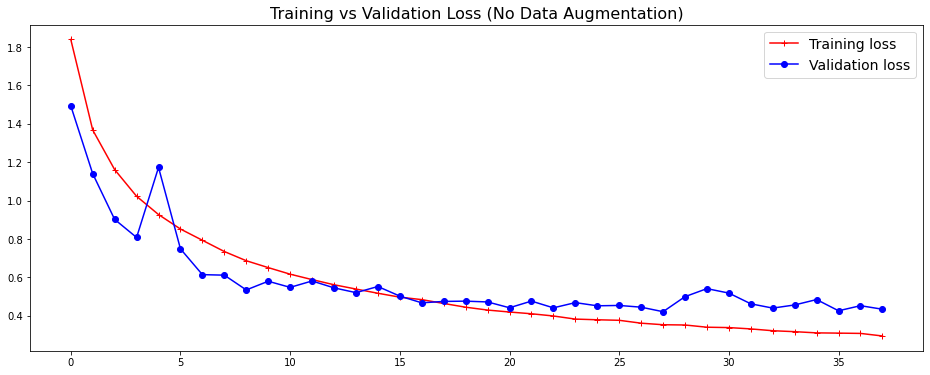

In [16]:
plt.figure(figsize=(16,6))
plt.plot(history.history['loss'], 'r+-', label = "Training loss")
plt.plot(history.history['val_loss'], 'bo-', label = "Validation loss")
plt.title("Training vs Validation Loss (No Data Augmentation)", fontsize = 16)
plt.legend(fontsize=14)
plt.show()

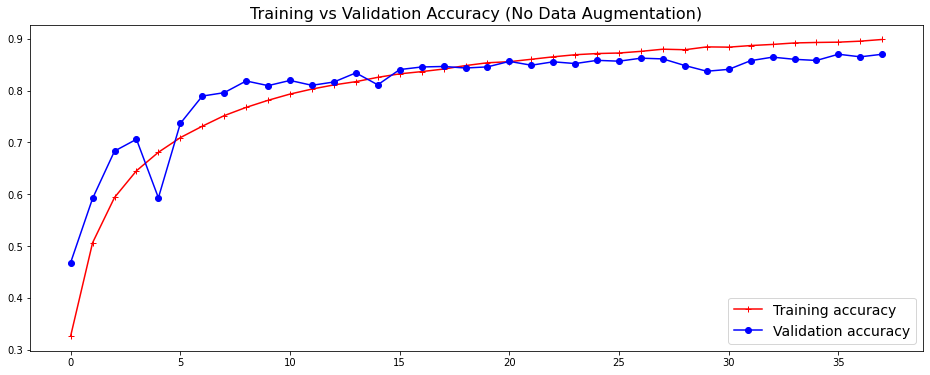

In [17]:
plt.figure(figsize=(16,6))
plt.plot(history.history['accuracy'], 'r+-', label = "Training accuracy")
plt.plot(history.history['val_accuracy'], 'bo-', label = "Validation accuracy")
plt.yticks(np.linspace(0.3,0.9,7))
plt.title("Training vs Validation Accuracy (No Data Augmentation)", fontsize = 16)
plt.legend(fontsize=14, loc = 'lower right')
plt.show()

#### Next i am test how well my model performs by plotting a confusion matrix based on its predictions and printing out the classification report.

In [18]:
# setting suppress to True to obtain float numbers instead of scientific notation
np.set_printoptions(suppress=True)

pred_1 = model.predict(X_test)
y_pred_1 = np.argmax(pred_1, axis = 1)

A confusion matrix is a table that is often used to describe the performance of a classification model (or "classifier") on a set of test data for which the true values are known.

In [19]:
conf_matrix_1 = confusion_matrix(y_test, y_pred_1)
conf_matrix_1

array([[852,  10,  31,  23,  13,   1,   4,  11,  28,  27],
       [  9, 916,   0,   3,   1,   3,   5,   0,  12,  51],
       [ 36,   0, 786,  47,  41,  35,  30,  19,   4,   2],
       [ 11,   2,  27, 763,  30, 110,  30,  17,   5,   5],
       [  5,   1,  40,  55, 802,  15,  30,  48,   2,   2],
       [  3,   0,  32, 129,  25, 766,   6,  39,   0,   0],
       [  6,   2,  29,  57,  11,  10, 882,   1,   1,   1],
       [  9,   1,  12,  20,  23,  24,   2, 906,   0,   3],
       [ 37,  10,   6,   7,   2,   2,   1,   6, 916,  13],
       [  9,  35,   3,   9,   0,   2,   6,   6,  11, 919]])

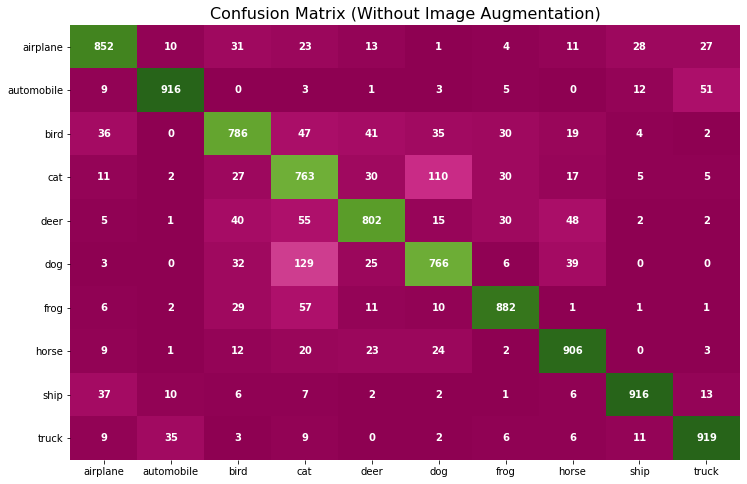

In [20]:
# Plotting the confusion matrix using seaborns' heatmap

plt.figure(figsize=(12,8))
sns.heatmap(conf_matrix_1, cmap = 'PiYG', annot = True, fmt = '.0f', cbar = False,
            annot_kws = {
            'weight':'bold'},
           xticklabels = label_names, yticklabels = label_names)
plt.title("Confusion Matrix (Without Image Augmentation)", fontsize = 16)
plt.show()

A Classification report is used to measure the quality of predictions from a classification algorithm. How many predictions are True and how many are False.

In [21]:
# Printing the classification report based on how well our model performed

print(classification_report(y_test, y_pred_1, target_names = label_names))

              precision    recall  f1-score   support

    airplane       0.87      0.85      0.86      1000
  automobile       0.94      0.92      0.93      1000
        bird       0.81      0.79      0.80      1000
         cat       0.69      0.76      0.72      1000
        deer       0.85      0.80      0.82      1000
         dog       0.79      0.77      0.78      1000
        frog       0.89      0.88      0.88      1000
       horse       0.86      0.91      0.88      1000
        ship       0.94      0.92      0.93      1000
       truck       0.90      0.92      0.91      1000

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000



### Visualizing my model predictions

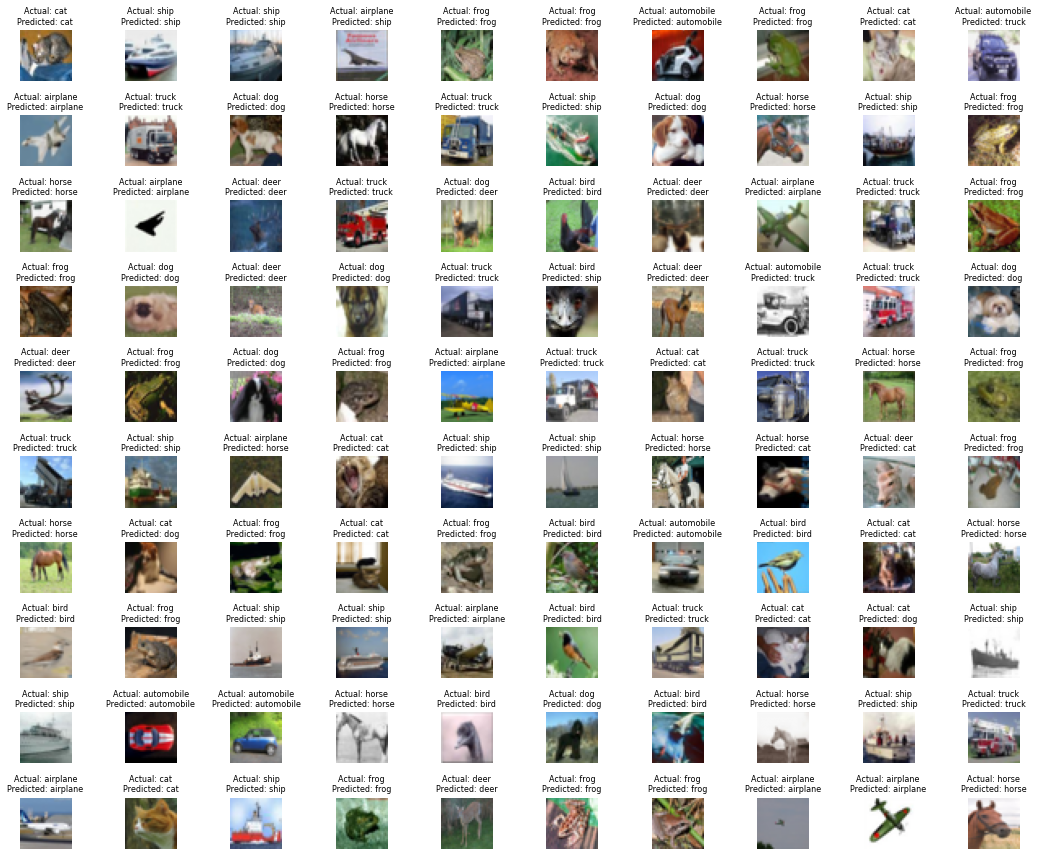

In [22]:
plt.figure(figsize=(15,12))
for i in range (100):
    plt.subplot(10, 10, i+1)
    plt.imshow(X_test[i])
    plt.title(f"Actual: {np.array(label_names)[y_test[i]]}\nPredicted: {np.array(label_names)[y_pred_1[i]]}", fontsize = 8)
    plt.axis("off")
plt.tight_layout()
plt.show()

### 2.0 Image Augmentation

Data Augmentation artificially increases the size of the training set by generating variants of an image. This reduces the risk of overfitting by forcing the model to be tolerant to variations in the position, orientaion, and size of the objects in image. This can be done by flipping or shifting the image horizontally or vertically, adding more lighting or contrast, zoming in or out, cropping the image etc. 

By combinning these transformations, we can significantly increase the size of our training set.

In [23]:
# Creating an image generator

train_datagen = ImageDataGenerator(
    rotation_range = 15,
    zoom_range = 0.2,
    width_shift_range = 0.15,
    height_shift_range = 0.15
)

train_generator = train_datagen.flow(X_train, y_train_cat, batch_size = 32)

#### Testing our Generator on a sample image

In [24]:
# Creating a dummy variable

X_dummy = X_train[8]
X_dummy = X_dummy[np.newaxis, ...]

example_generator = train_datagen.flow(X_dummy, batch_size = 1)

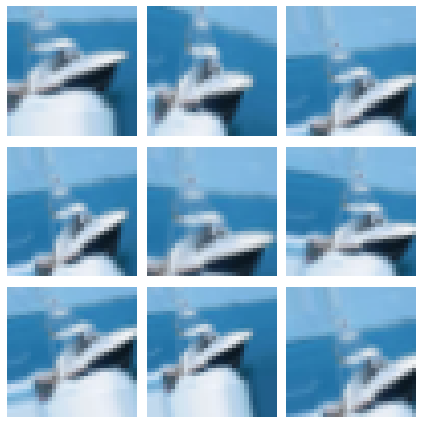

In [25]:
plt.figure(figsize=(6,6))
for i in range(9):
    plt.subplot(3,3,i+1)
    batch = example_generator.next()
    image = batch[0].astype(np.float64)
    plt.imshow(image)
    plt.axis('off')
plt.tight_layout()
plt.show()

In [26]:
from functools import partial

np.random.seed(42)
tf.random.set_seed(42)

keras.backend.clear_session()

DefaultConv = partial(keras.layers.Conv2D, strides = 1, kernel_size = 3, padding = 'same', activation = 'relu')

model = keras.models.Sequential([
    DefaultConv(filters = 32, input_shape = [32,32,3]),
    keras.layers.BatchNormalization(),
    DefaultConv(filters = 32, kernel_size = 5),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Dropout(0.2),
    
    DefaultConv(filters = 64),
    keras.layers.BatchNormalization(),
    DefaultConv(filters = 64),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Dropout(0.3),
    
    DefaultConv(filters = 128),
    keras.layers.BatchNormalization(),
    DefaultConv(filters = 128),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Dropout(0.4),
    
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation = 'relu', kernel_initializer = 'he_normal', use_bias = False),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(10, activation = 'softmax'),
])

In [27]:
Checkpoint_cb = keras.callbacks.ModelCheckpoint("Data_Augmentation_model.h5", save_best_only=True)
Earlystopping_cb = keras.callbacks.EarlyStopping(patience=10)

callback = [Checkpoint_cb, Earlystopping_cb]

In [28]:
model.compile(loss="categorical_crossentropy", metrics=['accuracy'],
             optimizer = 'nadam')

In [29]:
history = model.fit(train_generator, epochs = 100, steps_per_epoch = len(X_train) / 32,
    validation_data = (X_valid, y_valid_cat),
    callbacks=callback)

Epoch 1/100
1406/1406 [==============================] - 32s 22ms/step - loss: 2.2024 - accuracy: 0.2215 - val_loss: 1.6201 - val_accuracy: 0.4002
Epoch 2/100
1406/1406 [==============================] - 30s 21ms/step - loss: 1.6981 - accuracy: 0.3732 - val_loss: 1.3503 - val_accuracy: 0.5080
Epoch 3/100
1406/1406 [==============================] - 32s 23ms/step - loss: 1.5224 - accuracy: 0.4520 - val_loss: 1.7533 - val_accuracy: 0.4674
Epoch 4/100
1406/1406 [==============================] - 31s 22ms/step - loss: 1.3642 - accuracy: 0.5176 - val_loss: 1.0976 - val_accuracy: 0.6172
Epoch 5/100
1406/1406 [==============================] - 32s 22ms/step - loss: 1.2628 - accuracy: 0.5603 - val_loss: 1.0545 - val_accuracy: 0.6292
Epoch 6/100
1406/1406 [==============================] - 31s 22ms/step - loss: 1.1730 - accuracy: 0.5904 - val_loss: 0.9652 - val_accuracy: 0.6786
Epoch 7/100
1406/1406 [==============================] - 31s 22ms/step - loss: 1.1102 - accuracy: 0.6176 - val_loss: 0

In [30]:
model = keras.models.load_model('Data_Augmentation_model.h5')

model.evaluate(X_test, y_test_cat)

313/313 [==============================] - 1s 3ms/step - loss: 0.5562 - accuracy: 0.8092


[0.556232750415802, 0.8091999888420105]

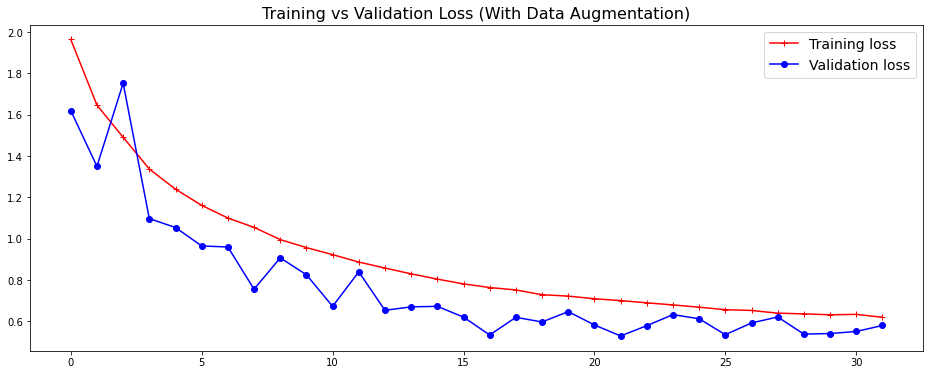

In [31]:
plt.figure(figsize=(16,6))
plt.plot(history.history['loss'], 'r+-', label = "Training loss")
plt.plot(history.history['val_loss'], 'bo-', label = "Validation loss")
plt.title("Training vs Validation Loss (With Data Augmentation)", fontsize = 16)
plt.legend(fontsize=14)
plt.show()

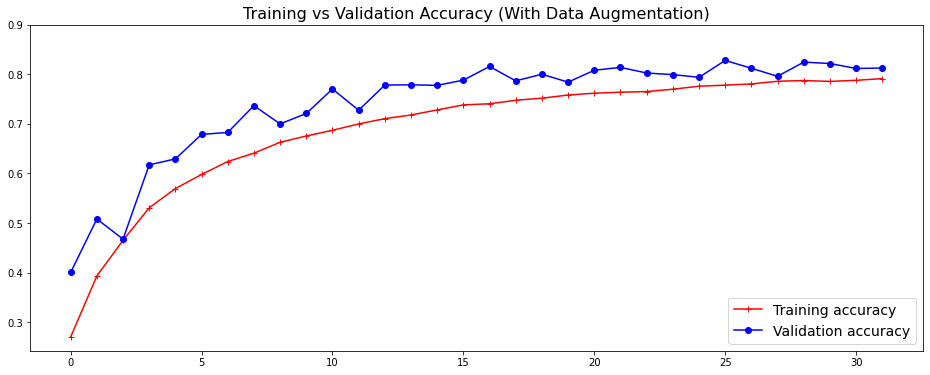

In [32]:
plt.figure(figsize=(16,6))
plt.plot(history.history['accuracy'], 'r+-', label = "Training accuracy")
plt.plot(history.history['val_accuracy'], 'bo-', label = "Validation accuracy")
plt.yticks(np.linspace(0.3,0.9,7))
plt.title("Training vs Validation Accuracy (With Data Augmentation)", fontsize = 16)
plt.legend(fontsize=14, loc = 'lower right')
plt.show()

In [33]:
pred_2 = model.predict(X_test)
y_pred_2 = np.argmax(pred_2, axis = 1)

In [34]:
conf_matrix_2 = confusion_matrix(y_test, y_pred_2)
conf_matrix_2

array([[847,  13,  17,   9,  22,   1,   8,  17,  40,  26],
       [  4, 930,   0,   1,   1,   1,   3,   0,   4,  56],
       [ 56,   2, 617,  33,  53,  37, 171,  22,   3,   6],
       [ 15,   7,  22, 650,  41,  77, 133,  28,  10,  17],
       [  7,   2,  23,  27, 754,   8, 138,  36,   5,   0],
       [  2,   2,  18, 150,  35, 658,  81,  49,   1,   4],
       [  4,   2,   7,  17,   6,   2, 955,   3,   3,   1],
       [  8,   0,   6,  21,  37,  13,  22, 885,   1,   7],
       [ 46,  22,   2,   3,   0,   1,   8,   4, 886,  28],
       [ 21,  44,   0,   3,   1,   1,   7,   7,   6, 910]])

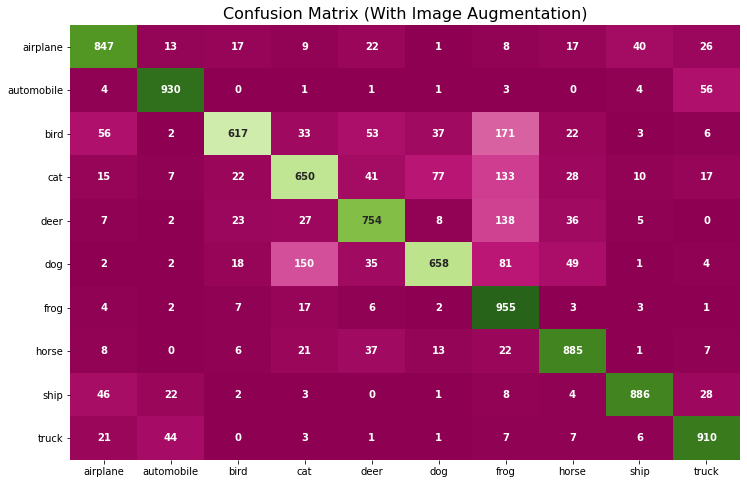

In [35]:
# Plotting the confusion matrix using seaborns' heatmap

plt.figure(figsize=(12,8))
sns.heatmap(conf_matrix_2, cmap = 'PiYG', annot = True, fmt = '.0f', cbar = False,
            annot_kws = {
            'weight':'bold'},
           xticklabels = label_names, yticklabels = label_names)
plt.title("Confusion Matrix (With Image Augmentation)", fontsize = 16)
plt.show()

In [36]:
# Printing the classification report based on how well our model performed

print(classification_report(y_test, y_pred_2, target_names = label_names))

              precision    recall  f1-score   support

    airplane       0.84      0.85      0.84      1000
  automobile       0.91      0.93      0.92      1000
        bird       0.87      0.62      0.72      1000
         cat       0.71      0.65      0.68      1000
        deer       0.79      0.75      0.77      1000
         dog       0.82      0.66      0.73      1000
        frog       0.63      0.95      0.76      1000
       horse       0.84      0.89      0.86      1000
        ship       0.92      0.89      0.90      1000
       truck       0.86      0.91      0.89      1000

    accuracy                           0.81     10000
   macro avg       0.82      0.81      0.81     10000
weighted avg       0.82      0.81      0.81     10000



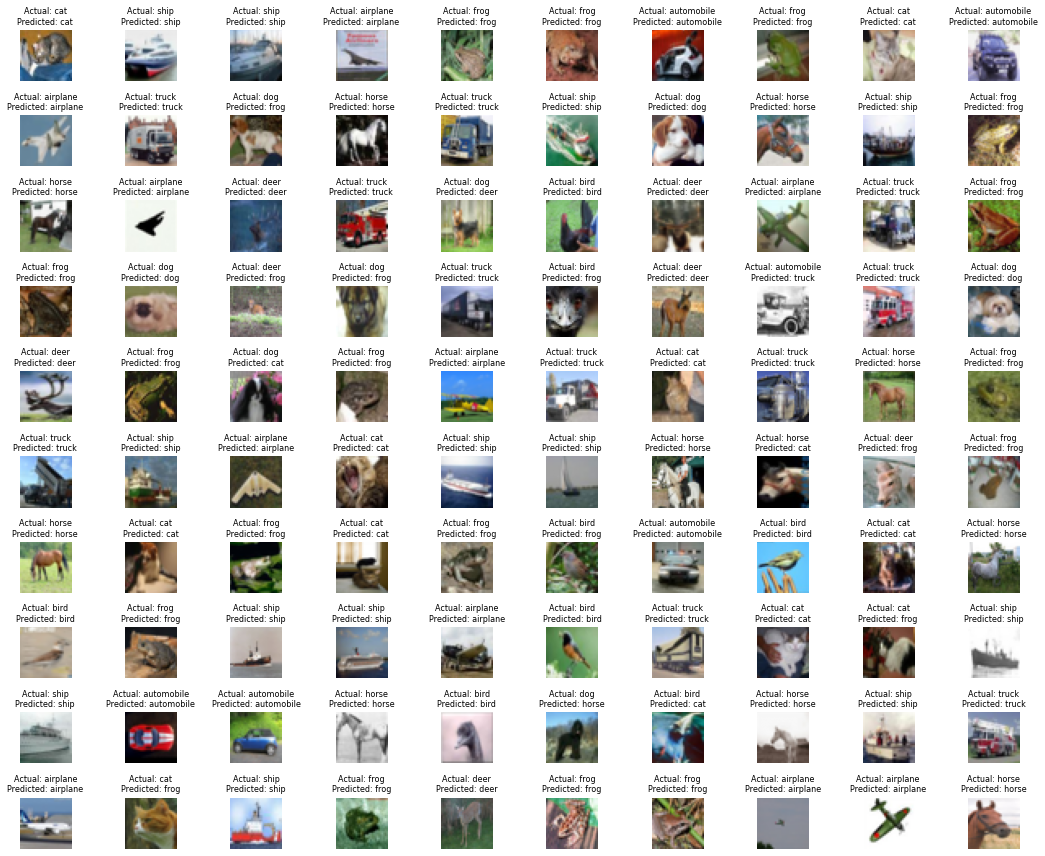

In [37]:
plt.figure(figsize=(15,12))
for i in range (100):
    plt.subplot(10, 10, i+1)
    plt.imshow(X_test[i])
    plt.title(f"Actual: {np.array(label_names)[y_test[i]]}\nPredicted: {np.array(label_names)[y_pred_2[i]]}", fontsize = 8)
    plt.axis("off")
plt.tight_layout()
plt.show()

## 3.0 Using a Pretrained model

In general, it is advisable to use pretrained networks for image classification tasks to save yourself the hassle of tuning paramters. 

Keras has a number of pretrained networks that can be available with a single line of code. These networks have been trained on the `imagenet` dataset and have won previous ILSVRC challenges.

In this section, i will be using the ResNet50 a variation of the ResNet152 that won the 2015 ILSVRC challenge.


In [38]:
# Loading the dataset again because the pretrained network assumes the pixels range from 0 ~ 255. 
(X_trainfull, y_trainfull), (X_test, y_test) = keras.datasets.cifar10.load_data()

#Splitting the trainfull set into train and validation set
X_train, X_valid = X_trainfull[:-5_000], X_trainfull[-5_000:]
y_train, y_valid = y_trainfull[:-5_000], y_trainfull[-5_000:]

First, i will preprocess the input image because most pretrained models were trained on 224 X 224 pixel images (and the model expects the same dimesion). Every pretrained network has a `preprocess_input() function` that can be used to preprocess images

In [39]:
def preprocess_ResNet50_input(input_images):
    input_images = input_images.astype('float32')
    preprocessed_images = keras.applications.resnet50.preprocess_input(input_images)
    return preprocessed_images

In [40]:
# Applying the preprocessing function

X_train_processed = preprocess_ResNet50_input(X_train)
X_valid_processed = preprocess_ResNet50_input(X_valid)
X_test_processed = preprocess_ResNet50_input(X_test)

In [41]:
# Building the model

def BuildModel():
    
    # Our input images have a 32,32,3 dimension
    inputs = keras.layers.Input(shape=(32,32,3))
    
    # Next we need to upsample our 32 x 32 images to 224 x 224 using size (7,7).
    resized = keras.layers.UpSampling2D(size=(7,7))(inputs)
    
    # Next we build our base model from the ReseNet50 pretrained networks and apply the resized input to it
    base_model = keras.applications.resnet50.ResNet50(input_shape = [224,224,3],
                                            include_top = False,
                                            weights = 'imagenet')(resized)
    
    
    # Next, we build our model using the functional API
    avg = keras.layers.GlobalAveragePooling2D()(base_model)
    Flatten = keras.layers.Flatten()(avg)
    dense1 = keras.layers.Dense(1024, activation='relu', kernel_initializer='he_normal')(Flatten)
    dense2 = keras.layers.Dense(512, activation='relu', kernel_initializer='he_normal')(dense1)
    output = keras.layers.Dense(10, activation='softmax')(dense2)
    model = keras.Model(inputs=[inputs], outputs=[output])
    return model


In [42]:
keras.backend.clear_session()

np.random.seed(42)
tf.random.set_seed(42)

model = BuildModel()
model.summary()

94773248/94765736 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 224, 224, 3)       0         
_________________________________________________________________
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              2098176   
______________________________________________________________

In [43]:
Checkpoint_cb = keras.callbacks.ModelCheckpoint("ResNet50_model.h5", save_best_only=True)

callback = [Checkpoint_cb]

Next, i'll compile and train my model on the preprocessed input images.

#### NOTE: I tried different configurations by playing the number of Dense layers, neurons per layer, batch size, optimizer before settling for the options below because they gave me the best accuracy. You can try out several configurations, perhaps another pretrained network, and even reach 97% accuracy!!!


In [44]:
model.compile(loss='sparse_categorical_crossentropy', metrics = ['accuracy'], 
             optimizer = keras.optimizers.SGD())

history = model.fit(X_train_processed, y_train, batch_size = 64, 
                    validation_data = (X_valid_processed, y_valid),
                    epochs = 5, callbacks=callback)

Epoch 1/5
704/704 [==============================] - 233s 325ms/step - loss: 0.7449 - accuracy: 0.7571 - val_loss: 0.2573 - val_accuracy: 0.9122
Epoch 2/5
704/704 [==============================] - 227s 323ms/step - loss: 0.1106 - accuracy: 0.9649 - val_loss: 0.2417 - val_accuracy: 0.9234
Epoch 3/5
704/704 [==============================] - 227s 323ms/step - loss: 0.0406 - accuracy: 0.9887 - val_loss: 0.1530 - val_accuracy: 0.9524
Epoch 4/5
704/704 [==============================] - 227s 323ms/step - loss: 0.0133 - accuracy: 0.9976 - val_loss: 0.4507 - val_accuracy: 0.8880
Epoch 5/5
704/704 [==============================] - 227s 323ms/step - loss: 0.0210 - accuracy: 0.9942 - val_loss: 0.2698 - val_accuracy: 0.9328


In [45]:
model = keras.models.load_model("ResNet50_model.h5")
model.evaluate(X_test_processed, y_test)

313/313 [==============================] - 18s 55ms/step - loss: 0.1699 - accuracy: 0.9469


[0.1698681116104126, 0.9469000101089478]

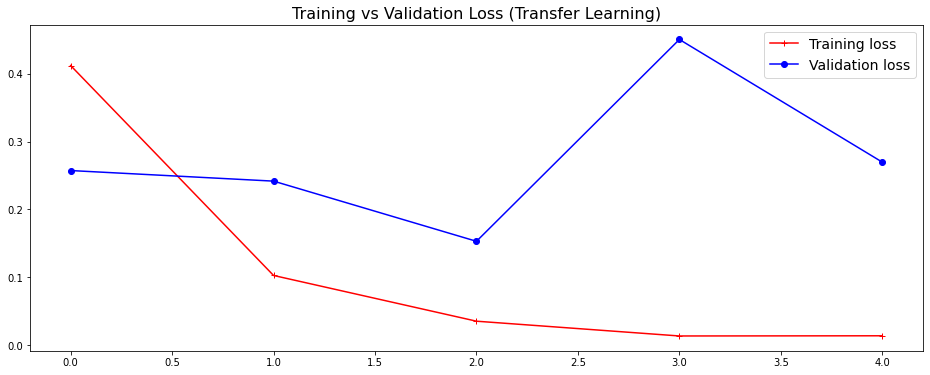

In [46]:
plt.figure(figsize=(16,6))
plt.plot(history.history['loss'], 'r+-', label = "Training loss")
plt.plot(history.history['val_loss'], 'bo-', label = "Validation loss")
plt.title("Training vs Validation Loss (Transfer Learning)", fontsize = 16)
plt.legend(fontsize=14)
plt.show()

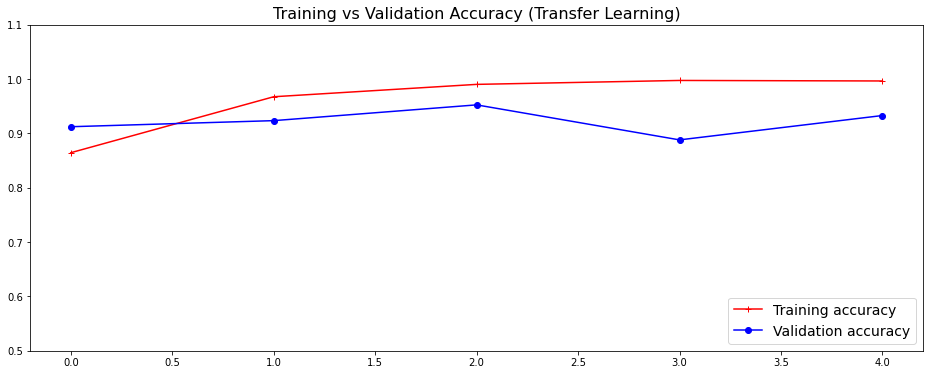

In [47]:
plt.figure(figsize=(16,6))
plt.plot(history.history['accuracy'], 'r+-', label = "Training accuracy")
plt.plot(history.history['val_accuracy'], 'bo-', label = "Validation accuracy")
plt.yticks(np.linspace(0.5,1.1,7))
plt.title("Training vs Validation Accuracy (Transfer Learning)", fontsize = 16)
plt.legend(fontsize=14, loc = 'lower right')
plt.show()

In [48]:
pred_3 = model.predict(X_test_processed)
y_pred_3 = np.argmax(pred_3, axis = 1)

In [49]:
conf_matrix_3 = confusion_matrix(y_test, y_pred_3)
conf_matrix_3

array([[950,   1,  10,   4,   3,   0,   1,   1,  22,   8],
       [  1, 969,   0,   0,   0,   0,   0,   1,   5,  24],
       [ 13,   0, 923,  16,  27,   6,  12,   1,   1,   1],
       [  3,   0,   6, 896,  14,  65,   9,   1,   2,   4],
       [  1,   0,   6,   7, 958,   4,   6,  15,   3,   0],
       [  0,   0,   5,  62,  13, 911,   0,   8,   1,   0],
       [  3,   0,   5,  20,   2,   5, 965,   0,   0,   0],
       [  5,   0,   4,   4,  20,  12,   1, 954,   0,   0],
       [  8,   4,   1,   1,   0,   1,   0,   0, 980,   5],
       [  6,  25,   1,   0,   0,   0,   0,   1,   4, 963]])

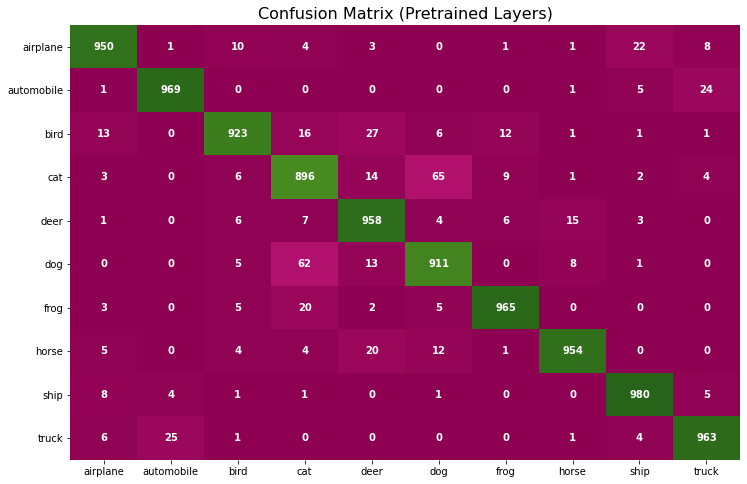

In [50]:
# Plotting the confusion matrix using seaborns' heatmap

plt.figure(figsize=(12,8))
sns.heatmap(conf_matrix_3, cmap = 'PiYG', annot = True, fmt = '.0f', cbar = False,
            annot_kws = {
            'weight':'bold'},
           xticklabels = label_names, yticklabels = label_names)
plt.title("Confusion Matrix (Pretrained Layers)", fontsize = 16)
plt.show()

In [51]:
# Printing the classification report based on how well our model performed

print(classification_report(y_test, y_pred_3, target_names = label_names))

              precision    recall  f1-score   support

    airplane       0.96      0.95      0.95      1000
  automobile       0.97      0.97      0.97      1000
        bird       0.96      0.92      0.94      1000
         cat       0.89      0.90      0.89      1000
        deer       0.92      0.96      0.94      1000
         dog       0.91      0.91      0.91      1000
        frog       0.97      0.96      0.97      1000
       horse       0.97      0.95      0.96      1000
        ship       0.96      0.98      0.97      1000
       truck       0.96      0.96      0.96      1000

    accuracy                           0.95     10000
   macro avg       0.95      0.95      0.95     10000
weighted avg       0.95      0.95      0.95     10000



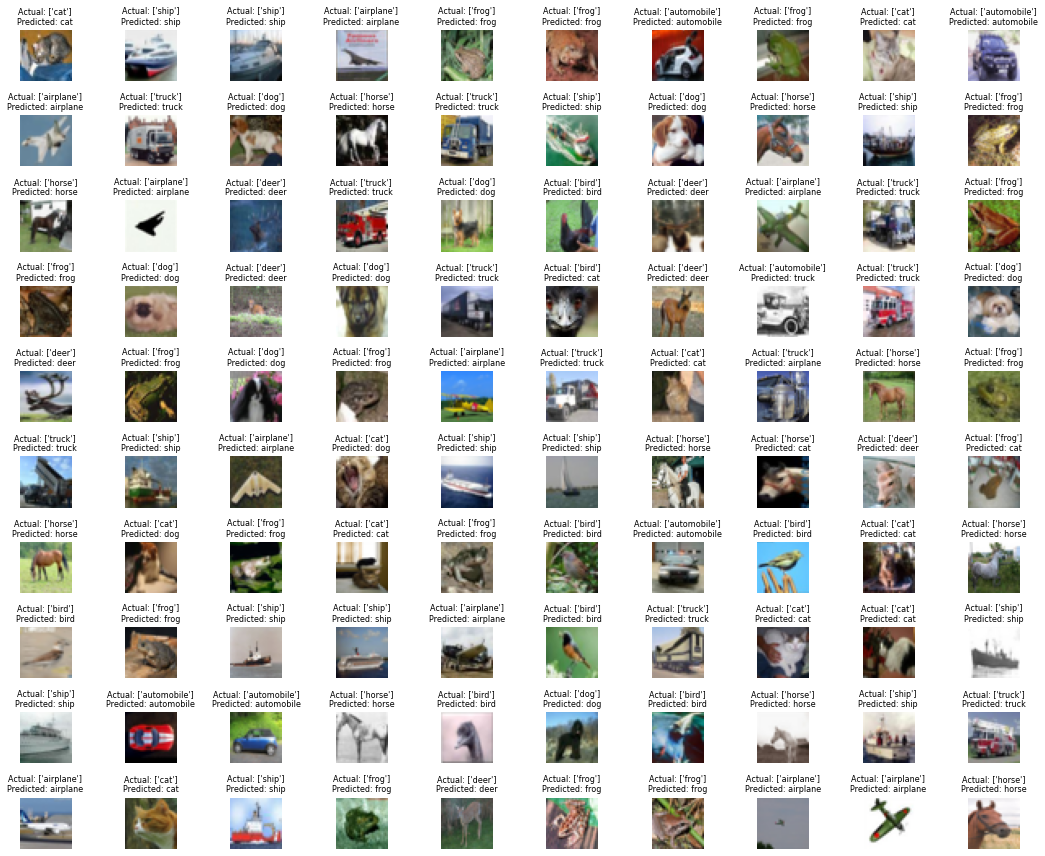

In [52]:
plt.figure(figsize=(15,12))
for i in range (100):
    plt.subplot(10, 10, i+1)
    plt.imshow(X_test[i])
    plt.title(f"Actual: {np.array(label_names)[y_test[i]]}\nPredicted: {np.array(label_names)[y_pred_3[i]]}", fontsize = 8)
    plt.axis("off")
plt.tight_layout()
plt.show()

In this notebook, we trained several models with all having at least 85% accuracy on the test set, which is not bad considering they are vanilla models. We also used a pretrained model (ResNet50) and achieved 95% accuracy on the test set. 

# $The$ $End.$ $Please$ $Upvote$